In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import copy
import numpy as np

import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [2]:
class DatasetMNIST(data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        data = pd.read_csv(dataset_path)
        self.xs = data.values[:, 1:].reshape(-1, 1, 28, 28)
        self.ys = data.values[:, 0]
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.xs[index], self.ys[index]
        x = torch.FloatTensor(x)
        if self.transform is not None:
            x = self.transform(x)
        y = torch.LongTensor([y])[0]
        return x, y

    def __len__(self):
        return len(self.xs)

In [3]:
class DatasetNotMNIST(data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.xs_paths = []
        self.ys = []
        for lable_num, label in enumerate(os.listdir(dataset_path)):
            lable_dir = os.path.join(dataset_path, label)
            for root, _, files in os.walk(lable_dir):
                self.ys += [lable_num] * len(files)
                self.xs_paths += list(map(lambda file: os.path.abspath(os.path.join(root, file)), files))
        self.transform = transform

    def __getitem__(self, index):
        x_path, y = self.xs_paths[index], self.ys[index]
        x = io.imread(x_path).reshape(28, 28)
        x = torch.FloatTensor([x, x, x])
        if self.transform is not None:
            x = self.transform(x)
        y = torch.LongTensor([y])[0]
        return x, y

    def __len__(self):
        return len(self.ys)

In [4]:
transform = transforms.Normalize([128.0], [255.0])
mnist = DatasetMNIST(os.path.join("..", "datasets", "mnist.csv"), transform)
not_mnist = DatasetNotMNIST(os.path.join("..", "datasets", "notMNIST_small"), transform)

In [5]:
def split_dataset(dataset, val_part=0.2):
    n = len(dataset)
    n_val = int(n * val_part)
    n_train = n - n_val
    return torch.utils.data.random_split(dataset, [n_train, n_val])

In [6]:
mnist = dict(zip(["train", "val"], split_dataset(mnist)))
not_mnist = dict(zip(["train", "val"], split_dataset(not_mnist)))

In [7]:
def train(model, dataloader, criterion, optimizer, device, num_epochs=50):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_acc = 0.0
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_acc / len(dataloader[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                accs.append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    model.load_state_dict(best_model_wts)
    return model, accs

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class ModelMNIST(nn.Module):
    def __init__(self, function):
        super(ModelMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.fc1 = nn.Linear(8 * 22 * 22, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        if function is "sigmoid":
            self.function = nn.Sigmoid()
        elif function is "tanh":
            self.function = nn.Tanh()
        else:
            self.function = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 8 * 22 * 22)
        x = self.function(self.fc1(x))
        x = self.function(self.fc2(x))
        x = self.function(self.fc3(x))
        return x

In [10]:
mnist_loader = {x: data.DataLoader(mnist[x], 
                                   batch_size=64,
                                   shuffle=(x == "train"), 
                                   num_workers=4)
                for x in ['train', 'val']}

criterion = nn.CrossEntropyLoss()

In [11]:
accs = {}

In [12]:
function = "sigmoid"

print("Dataset: MNIST")
print("Activation function:", function)

model = ModelMNIST(function)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, accs[function] = train(model, mnist_loader, criterion, optimizer, device)

Dataset: MNIST
Activation function: sigmoid
Epoch 0/49
----------
train Loss: 2.3031 Acc: 0.1029
val Loss: 2.3009 Acc: 0.1135

Epoch 1/49
----------
train Loss: 2.3014 Acc: 0.1120
val Loss: 2.3005 Acc: 0.1135

Epoch 2/49
----------
train Loss: 2.3013 Acc: 0.1135
val Loss: 2.3002 Acc: 0.1135

Epoch 3/49
----------
train Loss: 2.3009 Acc: 0.1135
val Loss: 2.3001 Acc: 0.1135

Epoch 4/49
----------
train Loss: 2.3003 Acc: 0.1135
val Loss: 2.2993 Acc: 0.1135

Epoch 5/49
----------
train Loss: 2.2994 Acc: 0.1135
val Loss: 2.2980 Acc: 0.1135

Epoch 6/49
----------
train Loss: 2.2967 Acc: 0.1135
val Loss: 2.2929 Acc: 0.1135

Epoch 7/49
----------
train Loss: 2.2844 Acc: 0.1180
val Loss: 2.2697 Acc: 0.1565

Epoch 8/49
----------
train Loss: 2.2458 Acc: 0.3946
val Loss: 2.2192 Acc: 0.5625

Epoch 9/49
----------
train Loss: 2.1851 Acc: 0.5910
val Loss: 2.1478 Acc: 0.5900

Epoch 10/49
----------
train Loss: 2.1044 Acc: 0.6149
val Loss: 2.0623 Acc: 0.6570

Epoch 11/49
----------
train Loss: 2.0215 

In [13]:
function = "tanh"

print("Dataset: MNIST")
print("Activation function:", function)

model = ModelMNIST(function)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, accs[function] = train(model, mnist_loader, criterion, optimizer, device)

Dataset: MNIST
Activation function: tanh
Epoch 0/49
----------
train Loss: 1.5663 Acc: 0.6813
val Loss: 1.1392 Acc: 0.8800

Epoch 1/49
----------
train Loss: 1.0692 Acc: 0.8949
val Loss: 1.0308 Acc: 0.9080

Epoch 2/49
----------
train Loss: 0.9906 Acc: 0.9213
val Loss: 0.9862 Acc: 0.9185

Epoch 3/49
----------
train Loss: 0.9530 Acc: 0.9350
val Loss: 0.9587 Acc: 0.9265

Epoch 4/49
----------
train Loss: 0.9320 Acc: 0.9401
val Loss: 0.9462 Acc: 0.9280

Epoch 5/49
----------
train Loss: 0.9138 Acc: 0.9474
val Loss: 0.9387 Acc: 0.9280

Epoch 6/49
----------
train Loss: 0.9009 Acc: 0.9536
val Loss: 0.9256 Acc: 0.9360

Epoch 7/49
----------
train Loss: 0.8869 Acc: 0.9584
val Loss: 0.9191 Acc: 0.9405

Epoch 8/49
----------
train Loss: 0.8793 Acc: 0.9627
val Loss: 0.9192 Acc: 0.9390

Epoch 9/49
----------
train Loss: 0.8713 Acc: 0.9654
val Loss: 0.9116 Acc: 0.9430

Epoch 10/49
----------
train Loss: 0.8637 Acc: 0.9699
val Loss: 0.9112 Acc: 0.9400

Epoch 11/49
----------
train Loss: 0.8575 Acc

In [14]:
function = "relu"

print("Dataset: MNIST")
print("Activation function:", function)

model = ModelMNIST(function)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, accs[function] = train(model, mnist_loader, criterion, optimizer, device)

Dataset: MNIST
Activation function: relu
Epoch 0/49
----------
train Loss: 1.6533 Acc: 0.4230
val Loss: 0.3923 Acc: 0.8795

Epoch 1/49
----------
train Loss: 0.3269 Acc: 0.9036
val Loss: 0.2867 Acc: 0.9150

Epoch 2/49
----------
train Loss: 0.2107 Acc: 0.9334
val Loss: 0.1923 Acc: 0.9445

Epoch 3/49
----------
train Loss: 0.1584 Acc: 0.9497
val Loss: 0.1946 Acc: 0.9405

Epoch 4/49
----------
train Loss: 0.1227 Acc: 0.9621
val Loss: 0.1642 Acc: 0.9475

Epoch 5/49
----------
train Loss: 0.1022 Acc: 0.9656
val Loss: 0.1595 Acc: 0.9475

Epoch 6/49
----------
train Loss: 0.0829 Acc: 0.9710
val Loss: 0.1878 Acc: 0.9455

Epoch 7/49
----------
train Loss: 0.0620 Acc: 0.9794
val Loss: 0.1490 Acc: 0.9545

Epoch 8/49
----------
train Loss: 0.0527 Acc: 0.9815
val Loss: 0.2106 Acc: 0.9465

Epoch 9/49
----------
train Loss: 0.0371 Acc: 0.9876
val Loss: 0.1784 Acc: 0.9540

Epoch 10/49
----------
train Loss: 0.0323 Acc: 0.9895
val Loss: 0.1924 Acc: 0.9575

Epoch 11/49
----------
train Loss: 0.0353 Acc

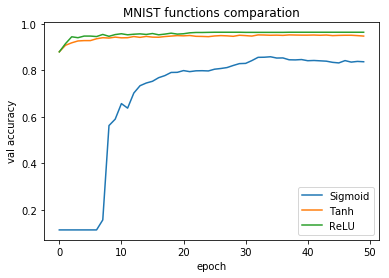

In [15]:
xs = list(range(50))
plot1, = plt.plot(xs, accs["sigmoid"])
plot2, = plt.plot(xs, accs["tanh"])
plot3, = plt.plot(xs, accs["relu"])

plt.title("MNIST functions comparation")
plt.legend([plot1, plot2, plot3], ["Sigmoid", "Tanh", "ReLU"])
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.show()

In [16]:
def get_collate_fn(add_noise=False):
    def collate_fn(data):
        xs, ys = zip(*data)
        xs = torch.stack(xs, 0)
        ys = torch.stack(ys, 0)
        if add_noise:
            xs += torch.randn_like(xs) / 10
        return xs, ys
    return collate_fn

not_mnist_loader = {x: data.DataLoader(not_mnist[x], 
                                       batch_size=32,
                                       shuffle=(x == "train"), 
                                       num_workers=4,
                                       collate_fn=get_collate_fn(x == "train"))
                    for x in ['train', 'val']}

model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model, notMNIST_accs = train(model, not_mnist_loader, criterion, optimizer, device, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4840 Acc: 0.8657
val Loss: 0.2703 Acc: 0.9196

Epoch 1/24
----------
train Loss: 0.2665 Acc: 0.9241
val Loss: 0.2227 Acc: 0.9356

Epoch 2/24
----------
train Loss: 0.2181 Acc: 0.9383
val Loss: 0.2005 Acc: 0.9407

Epoch 3/24
----------
train Loss: 0.2188 Acc: 0.9355
val Loss: 0.2221 Acc: 0.9279

Epoch 4/24
----------
train Loss: 0.1523 Acc: 0.9543
val Loss: 0.2542 Acc: 0.9244

Epoch 5/24
----------
train Loss: 0.2194 Acc: 0.9368
val Loss: 0.1626 Acc: 0.9485

Epoch 6/24
----------
train Loss: 0.1246 Acc: 0.9615
val Loss: 0.1754 Acc: 0.9487

Epoch 7/24
----------
train Loss: 0.1017 Acc: 0.9684
val Loss: 0.1663 Acc: 0.9503

Epoch 8/24
----------
train Loss: 0.0985 Acc: 0.9696
val Loss: 0.1718 Acc: 0.9501

Epoch 9/24
----------
train Loss: 0.0836 Acc: 0.9723
val Loss: 0.1663 Acc: 0.9551

Epoch 10/24
----------
train Loss: 0.1034 Acc: 0.9700
val Loss: 0.1851 Acc: 0.9399

Epoch 11/24
----------
train Loss: 0.0716 Acc: 0.9774
val Loss: 0.1608 Acc: 0.9554

Ep

In [17]:
print("Max accuracy for notMNIST dataset:", max(notMNIST_accs))

Max accuracy for notMNIST dataset: 0.9583333333333334
